In [1]:
# Setup
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/My\ Drive/BDSA_Project/SSD
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/BDSA_Project/SSD
pretrained_caffe_ssd  pytorch-ssd3.ipynb  ssd.ipynb
pytorch-ssd2.ipynb    pytorch-ssd.ipynb


In [2]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
import json
!pip install xmltodict
from keras.optimizers import Adam, SGD
import xmltodict
from google.colab.patches import cv2_imshow
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [3]:
directory = "../annotations/"
image_directory = "../images/"

In [4]:
cvNet = cv2.dnn.readNetFromCaffe('./pretrained_caffe_ssd/architecture.txt','./pretrained_caffe_ssd/weights.caffemodel')

In [5]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [6]:
jsonfiles= []
for i in os.listdir(directory):
  xml_file = open(directory+i)
  data_dict = xmltodict.parse(xml_file.read())
  xml_file.close()
  json_data = json.dumps(data_dict)
  json_dict = json.loads(json_data)
  jsonfiles.append(json_dict)
  
jsonfiles[0]

{'annotation': {'filename': 'maksssksksss100.png',
  'folder': 'images',
  'object': [{'bndbox': {'xmax': '245',
     'xmin': '189',
     'ymax': '88',
     'ymin': '30'},
    'difficult': '0',
    'name': 'with_mask',
    'occluded': '0',
    'pose': 'Unspecified',
    'truncated': '0'},
   {'bndbox': {'xmax': '400', 'xmin': '387', 'ymax': '75', 'ymin': '54'},
    'difficult': '0',
    'name': 'with_mask',
    'occluded': '0',
    'pose': 'Unspecified',
    'truncated': '0'},
   {'bndbox': {'xmax': '163', 'xmin': '118', 'ymax': '126', 'ymin': '87'},
    'difficult': '0',
    'name': 'with_mask',
    'occluded': '0',
    'pose': 'Unspecified',
    'truncated': '0'}],
  'segmented': '0',
  'size': {'depth': '3', 'height': '226', 'width': '400'}}}

In [7]:
column_names = ["name", "x1", "x2", "y1", "y2", "classname"]
df = pd.DataFrame(columns = column_names)
df

,name,x1,x2,y1,y2,classname


In [8]:
for jf in jsonfiles:
  one = False
  for o in jf['annotation']['object']:
    try:
      df.loc[len(df.index)] = [jf['annotation']['filename'], int(o['bndbox']['xmin']), int(o['bndbox']['xmax']), int(o['bndbox']['ymin']), int(o['bndbox']['ymax']), o['name']]
    except TypeError:
      one = True

  if (one):
    o = jf['annotation']['object']
    df.loc[len(df.index)] = [jf['annotation']['filename'], int(o['bndbox']['xmin']), int(o['bndbox']['xmax']), int(o['bndbox']['ymin']), int(o['bndbox']['ymax']), o['name']]

df.head()

,name,x1,x2,y1,y2,classname
0,maksssksksss100.png,189,245,30,88,with_mask
1,maksssksksss100.png,387,400,54,75,with_mask
2,maksssksksss100.png,118,163,87,126,with_mask
3,maksssksksss106.png,154,423,51,391,with_mask
4,maksssksksss101.png,48,164,294,400,with_mask


In [9]:
set(df['classname'])

{'mask_weared_incorrect', 'with_mask', 'without_mask'}

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


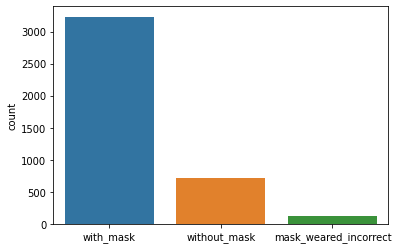

In [10]:
sns.countplot(list(df['classname']))

In [53]:
# 80 - 20 train/val test split

np.random.seed(100)

images_list = list(set(df['name']))
np.random.shuffle(images_list)

size = len(images_list)
t = int(0.8*size)

train_set = images_list[:t]
test_set = images_list[t:]

In [59]:
df_train = df[df.isin({'name': train_set})['name']]
df_test = df[df.isin({'name': test_set})['name']]

print(df_train,"\n")
print(df_test,"\n")

                     name   x1   x2   y1   y2     classname
0     maksssksksss100.png  189  245   30   88     with_mask
1     maksssksksss100.png  387  400   54   75     with_mask
2     maksssksksss100.png  118  163   87  126     with_mask
4     maksssksksss101.png   48  164  294  400     with_mask
5       maksssksksss1.png  321  354   34   69     with_mask
...                   ...  ...  ...  ...  ...           ...
4067  maksssksksss851.png   66  156  205  330     with_mask
4068   maksssksksss86.png   22   77  121  181     with_mask
4069   maksssksksss86.png  231  290   76  144     with_mask
4070   maksssksksss86.png  335  395  135  198  without_mask
4071   maksssksksss86.png   78  111  105  149  without_mask

[3224 rows x 6 columns] 

                     name   x1   x2   y1   y2  classname
3     maksssksksss106.png  154  423   51  391  with_mask
26    maksssksksss105.png  178  213  143  202  with_mask
27    maksssksksss105.png  280  312  103  145  with_mask
28    maksssksksss105.png

In [60]:
data = []
img_size = 124

with_mask = ['with_mask']
without_mask = ["without_mask"]
mask_weared_incorrect = ['mask_weared_incorrect']

labels={'mask_weared_incorrect':0, 'with_mask':1, 'without_mask':2}
for ind in df_train.index:
  x1, x2, y1, y2 = df_train['x1'][ind], df_train['x2'][ind], df_train['y1'][ind], df_train['y2'][ind]
  img = cv2.imread(os.path.join(image_directory,df_train['name'][ind]),1)
  img = img[y1:y2,x1:x2]
  img = cv2.resize(img,(img_size,img_size))
  data.append([img, labels[df_train['classname'][ind]]])
  # cv2_imshow(img)

random.shuffle(data)

1


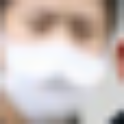

2


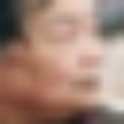

1


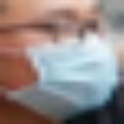

1


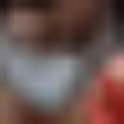

1


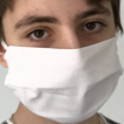

2


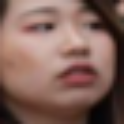

1


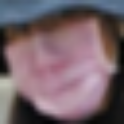

1


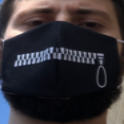

1


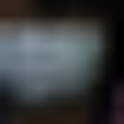

1


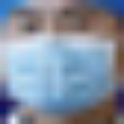

1


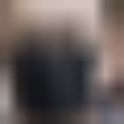

1


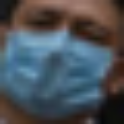

1


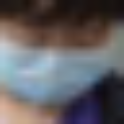

1


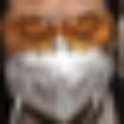

2


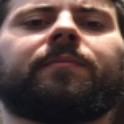

1


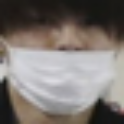

1


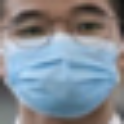

2


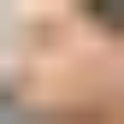

1


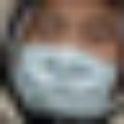

1


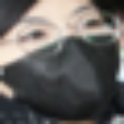

1


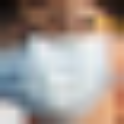

In [61]:
for i,d in enumerate(data):
  print(d[1])
  cv2_imshow(d[0])
  if(i==20):
    break

#TRAIN

In [63]:
X, Y = list(), list()
for features,label in data:
    X.append(features)
    temp = list([0,0,0])
    temp[label] = 1
    Y.append(temp)

X[0].shape

(124, 124, 3)

In [64]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)
print(Y.shape)

(3224, 3)


In [65]:
xtrain,xval,ytrain,yval=train_test_split(X, Y, train_size=0.7, random_state=42)

In [66]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 124, 124, 32)      896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 120, 120, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 60, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 460800)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 460800)           

In [68]:
def smooth_l1_loss(y_true, y_pred):
    return 100*tf.compat.v1.losses.huber_loss(y_true, y_pred)

In [69]:
adam = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.001, momentum=0.5, decay=0.1, nesterov=False)

model.compile(loss= 'categorical_crossentropy', #smooth_l1_loss, 
              optimizer=sgd,
              metrics=[
                'MeanSquaredError',
                'AUC',
                ]
              )

In [70]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

In [71]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=10,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/10
70/70 [==============================] - 11s 157ms/step - loss: 0.6305 - mean_squared_error: 0.1181 - auc: 0.8933 - val_loss: 0.5591 - val_mean_squared_error: 0.1045 - val_auc: 0.9199
Epoch 2/10
70/70 [==============================] - 10s 148ms/step - loss: 0.5979 - mean_squared_error: 0.1116 - auc: 0.9054 - val_loss: 0.5436 - val_mean_squared_error: 0.1012 - val_auc: 0.9266
Epoch 3/10
70/70 [==============================] - 10s 147ms/step - loss: 0.5825 - mean_squared_error: 0.1082 - auc: 0.9116 - val_loss: 0.5356 - val_mean_squared_error: 0.0996 - val_auc: 0.9290
Epoch 4/10
70/70 [==============================] - 10s 147ms/step - loss: 0.5674 - mean_squared_error: 0.1055 - auc: 0.9169 - val_loss: 0.5295 - val_mean_squared_error: 0.0984 - val_auc: 0.9306
Epoch 5/10
70/70 [==============================] - 10s 146ms/step - loss: 0.5632 - mean_squared_error: 0.1057 - auc: 0.9178 - val_loss: 0.5246 - val_mean_squared_error: 0.0974 - val_auc: 0.9315
Epoch 6/10
70/70 [=======

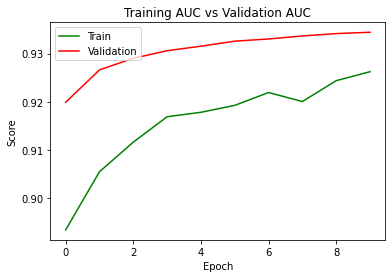

In [77]:
plt.plot(history.history['auc'],'g')
plt.plot(history.history['val_auc'],'r')
plt.title('Training AUC vs Validation AUC')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

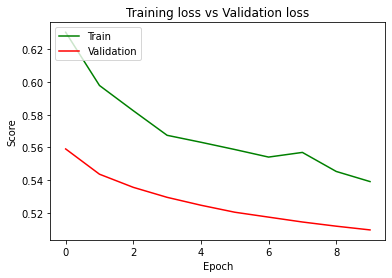

In [78]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'r')
plt.title('Training loss vs Validation loss')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

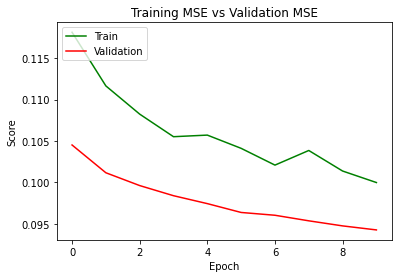

In [79]:
plt.plot(history.history['mean_squared_error'],'g')
plt.plot(history.history['val_mean_squared_error'],'r')
plt.title('Training MSE vs Validation MSE')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Model Testing

In [80]:
print(len(df_test["name"]),len(df_test["name"].unique()))

848 171


In [81]:
test = df_test.sample(15)
test

,name,x1,x2,y1,y2,classname
1057,maksssksksss285.png,66,209,99,235,with_mask
2888,maksssksksss611.png,156,166,85,104,with_mask
3935,maksssksksss843.png,1,59,132,215,with_mask
3405,maksssksksss695.png,196,220,118,143,with_mask
1234,maksssksksss347.png,8,57,147,198,without_mask
1339,maksssksksss370.png,135,241,135,263,without_mask
3196,maksssksksss684.png,228,243,79,98,with_mask
1568,maksssksksss410.png,55,67,60,74,with_mask
978,maksssksksss305.png,171,184,113,125,without_mask
1459,maksssksksss359.png,298,314,39,57,with_mask


In [82]:
gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign={'0':['mask_weared_incorrect',(255,0,0)], '1':['with_mask',(0,0,255)], '2':['without_mask',(0,255,0)]}

<Figure size 1008x1008 with 0 Axes>

In [83]:
for index, row in test.iterrows():
  image =  cv2.imread(os.path.join(image_directory,row['name']),1)
  image =  adjust_gamma(image, gamma=gamma)
  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  cvNet.setInput(blob)
  detections = cvNet.forward()

  for i in range(0, detections.shape[2]):
        try:
            temp = detections[0, 0, i, :]
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            # cv2_imshow(frame)
            confidence = detections[0, 0, i, 2]
            if confidence > 0.12:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                label_Y = np.argmax(result[0])
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)

        except:
          pass
          
  # axes.append(fig.add_subplot(rows, cols, index+1))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  if (index==10):
    break

Output hidden; open in https://colab.research.google.com to view.

Reference tutorial: https://www.kaggle.com/aman10kr/face-mask-detection-using-ssd-tutorial